In [15]:
import numpy as np
import onnxruntime as ort
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
onnx_model_path = "cnn1d_sentiment.onnx"
session = ort.InferenceSession(onnx_model_path)

In [3]:
embedder = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

In [4]:
def predict_sentiment(text):
    # Get embedding
    embedding = embedder.encode([text])  # shape: (1, 768)
    embedding = embedding.astype(np.float32)

    # Run through ONNX model
    ort_inputs = {session.get_inputs()[0].name: embedding}
    ort_outs = session.run(None, ort_inputs)
    logits = ort_outs[0].squeeze()  # shape: ()
    prob = 1 / (1 + np.exp(-logits))  # sigmoid

    # Binary prediction
    pred = int(prob > 0.5)
    return pred, float(prob)

In [5]:
text = "I don't like this movie."
pred, prob = predict_sentiment(text)
print(f"Sentiment: {pred} ({'positive' if pred == 1 else 'negative'}) (probability: {prob:.4f})")

Sentiment: 0 (negative) (probability: 0.1454)


In [7]:
test_df = pd.read_feather("data/test_embeddings.feather")

In [8]:
test_df

,text,sentiment,embeddings
0,yes black red fav colors really wanted colors ...,0,"[-0.015319691, 0.029470563, -0.010942006, 0.02..."
1,qu buy open house weekend ampm best value one ...,1,"[-0.055580236, 0.019168517, 0.008300844, 0.002..."
2,fran greet air thats okay hahahaha thanks,1,"[0.05550304, 0.033181395, -0.027894102, 0.0079..."
3,omg thats awesome goood luck u meet caaute cal...,1,"[0.0014827816, 0.09667131, -0.046894766, 0.017..."
4,hahahhaha good point,1,"[0.019305877, 0.13698456, -0.04215252, 0.01921..."
...,...,...,...
319995,beautiful shit weather happy see mod practice ...,0,"[-0.047691427, -0.060672514, -0.012338485, 0.0..."
319996,wouldnt fiftythousand followers hugh lauries n...,0,"[-0.01808973, 0.05361895, -0.0075201374, 0.060..."
319997,following also hope atleast get also wishes ge...,1,"[0.040130217, -0.016713306, -0.027665429, 0.00..."
319998,feel like havent decent swell since last fall ...,0,"[-0.03733373, -0.012787309, -0.0091675585, 0.0..."


In [12]:
def predict_sentiment_emb(embedding):
    embedding = embedding.reshape(1, -1)
    ort_inputs = {session.get_inputs()[0].name: embedding}
    ort_outs = session.run(None, ort_inputs)
    logits = ort_outs[0].squeeze()
    prob = 1 / (1 + np.exp(-logits))
    pred = int(prob > 0.5)
    return pred, float(prob)

In [13]:
# Inference for entire DataFrame
test_df['pred'], test_df['prob'] = zip(*test_df['embeddings'].map(predict_sentiment_emb))

In [14]:
test_df

,text,sentiment,embeddings,pred,prob
0,yes black red fav colors really wanted colors ...,0,"[-0.015319691, 0.029470563, -0.010942006, 0.02...",1,0.936591
1,qu buy open house weekend ampm best value one ...,1,"[-0.055580236, 0.019168517, 0.008300844, 0.002...",1,0.673553
2,fran greet air thats okay hahahaha thanks,1,"[0.05550304, 0.033181395, -0.027894102, 0.0079...",1,0.905181
3,omg thats awesome goood luck u meet caaute cal...,1,"[0.0014827816, 0.09667131, -0.046894766, 0.017...",1,0.836486
4,hahahhaha good point,1,"[0.019305877, 0.13698456, -0.04215252, 0.01921...",1,0.878531
...,...,...,...,...,...
319995,beautiful shit weather happy see mod practice ...,0,"[-0.047691427, -0.060672514, -0.012338485, 0.0...",1,0.619087
319996,wouldnt fiftythousand followers hugh lauries n...,0,"[-0.01808973, 0.05361895, -0.0075201374, 0.060...",1,0.719235
319997,following also hope atleast get also wishes ge...,1,"[0.040130217, -0.016713306, -0.027665429, 0.00...",1,0.655911
319998,feel like havent decent swell since last fall ...,0,"[-0.03733373, -0.012787309, -0.0091675585, 0.0...",0,0.190070


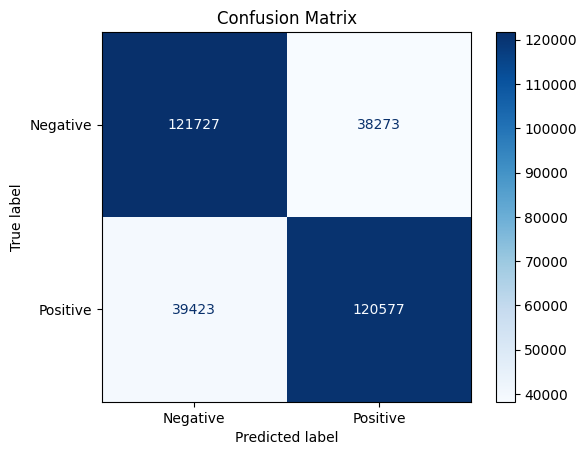

In [16]:
cm = confusion_matrix(test_df['sentiment'], test_df['pred'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()